In [ ]:
import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

# Webscraping

criando função para fazer dataset de texto a partir de 3 editorias determinadas no site.

In [ ]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [ ]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,RBI releases new index to measure growth of di...,The Reserve Bank of India (RBI) on Friday rele...,technology
1,CBSE website crashes after 2021 board exams da...,The Central Board of Secondary Education's (CB...,technology
2,UP residents complain of cyber fraud under pre...,Several reports of cyber fraud being committed...,technology
3,"Emergency fundraising, tech IPOs lead to recor...",Emergency corporate fundraising by sectors suc...,technology
4,Apple shares rise after JPMorgan says iPhone d...,Apple shares rose slightly on Thursday after J...,technology
5,Huawei removes Tencent games from app store ov...,Tencent on Friday said its online games have b...,technology
6,NPCI warns of fake news of extra charges on UP...,The National Payments Corporation of India (NP...,technology
7,Alphabet's drone unit Wing criticises new ID r...,Google parent Alphabet's drone delivery unit W...,technology
8,Elon Musk sold 3 more of his houses in Dec for...,Tesla CEO Elon Musk sold three more of his hou...,technology
9,"New Brexit agreement calls Netscape, Mozilla M...",The deal document that will govern the UK and ...,technology


In [ ]:
news_df.to_csv('news_df_mentorama.csv')

Para saber:

- *Token*: uma unidade do texto, pode ser uma palavra, uma frase, etc. 
- *Documento*: uma sequencia de tokens, por exemplo um livro ou um artigo 
- *Corpus*: um conjunto de documentos. 
- *Document Term Matrix*: uma matrix que descreve a frequencia de termos em um corpus
- *Stopwords*: palavras que não contém informação, que ocorrem com muita frequência.

Definindo função que processa o texto e retorna o texto tokenizado e sem stopwords, emoji, pontuação e números, etc:

In [ ]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.UNICODE_EMOJI])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [ ]:
rows, cols = news_df.shape

In [ ]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [ ]:
news_df.head()

,news_headline,news_article,news_category,token
0,RBI releases new index to measure growth of di...,The Reserve Bank of India (RBI) on Friday rele...,technology,"[reserve, bank, india, rbi, friday, released, ..."
1,CBSE website crashes after 2021 board exams da...,The Central Board of Secondary Education's (CB...,technology,"[central, board, secondary, education, cbse, w..."
2,UP residents complain of cyber fraud under pre...,Several reports of cyber fraud being committed...,technology,"[reports, cyber, fraud, committed, residents, ..."
3,"Emergency fundraising, tech IPOs lead to recor...",Emergency corporate fundraising by sectors suc...,technology,"[emergency, corporate, fundraising, sectors, a..."
4,Apple shares rise after JPMorgan says iPhone d...,Apple shares rose slightly on Thursday after J...,technology,"[apple, shares, rose, slightly, thursday, jpmo..."


# Word Embedding

Depois que temos o texto com tokens, vamos usar uma rede neural que recebe palavras e entrega vetores que representam ela em um espaço vetorial. 

# documentação importante:
https://spacy.io/usage

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 50.8 MB 142 kB/s eta 0:00:01
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-py3-none-any.whl size=50916640 sha256=5a17be1d76827dc6ea7ede6019e688be56c2d386f1d454deadfd206467af0dde
  Stored in directory: /private/var/folders/mv/tfzgrfr17wb3gtswfh_d3n5m0000gp/T/pip-ephem-wheel-cache-gwzwgd3c/wheels/b8/ae/ae/c63bae74a3b3e18b2fa35e179387e6cdeb03a1c479ed45c351
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

# Vetorizando cada palavra. 
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples. 

In [ ]:
vec_size = 300
list_of_matrix = []
for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [ ]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [ ]:
final_feature_matrix.shape

(75, 300)

# Clusterização de matérias:

Agora que temos um vetor que representa cada documento, vamos usar algum método de clusterização pra tentar recuperar as editorias selecionadas lá no início. Vamos rodar um k-means em cada vetor que representa um documento e (como é um teste), pedir 3 clusters para ele. 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Vamos ver como o k-means separou cada grupo e olhar o label verdadeiro para validar nosso método:

In [ ]:
print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

0     technology
2     technology
3     technology
6     technology
9     technology
10    technology
13    technology
14    technology
15    technology
21    technology
24    technology
64         world
Name: news_category, dtype: object
1     technology
4     technology
5     technology
7     technology
8     technology
11    technology
12    technology
16    technology
17    technology
18    technology
19    technology
20    technology
22    technology
23    technology
39        sports
51         world
52         world
53         world
54         world
55         world
56         world
57         world
58         world
59         world
60         world
61         world
62         world
63         world
65         world
66         world
67         world
68         world
69         world
70         world
71         world
72         world
73         world
74         world
Name: news_category, dtype: object
25    sports
26    sports
27    sports
28    sports
29    sports
30    sports
31

Conseguimos separar bem as editorias por assuntos.

# Notícia mais similar usando distância euclidiana

Vamos agora tentar identificar, dado um documento, qual é o documento mais similar a ele. 

In [ ]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position])
    print(df[closest_position])
    return tree.query(article_vec)[0], closest_position

In [ ]:
get_closest(final_feature_matrix, 30, news_df["news_article"])

All-rounder Yusuf Pathan has not been included in Baroda's squad for the upcoming Syed Mushtaq Ali Trophy. This is the first time in the history of the tournament that Yusuf has not been picked in the squad. Yusuf is the second-highest run-scorer for the two-time champions Baroda. He has aggregated 1,244 runs in the tournament at an average of 28.27.
Ex-India spinner Pragyan Ojha has called Ravichandran Ashwin the "bowling captain" of India's Test side. "Ashwin knows exactly what he wants to do...He's been to Australia and now he doesn't have to play for his spot...that's what is making a lot of difference for him," Ojha added. Ashwin has so far picked 10 wickets in the two Tests. 


(1.4684237715967863, 46)

# Explorando visualmente os resultados encontrados

Como estamos lidando com uma dimensão elevada (300) para cada documento, não conseguimos visualizar com clareza o que estamos clusterizando. Um método simples que permite explorar os resultados obtidos é reduzir a dimensão do problema para 2, 3 e fazer gráficos exploratórios que permitam visualizar os dados.


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2'])

In [ ]:
pca.explained_variance_ratio_

array([0.199772  , 0.07671219])

Aqui, vamos plotar o gráfico dos dois primeiros componentes e colorir eles com a cor associada à editoria real dele.

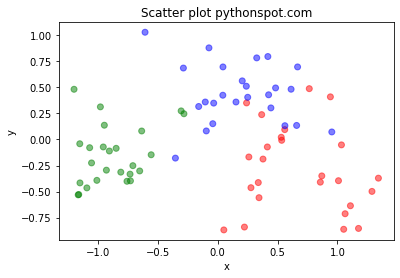

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create data

x = principalDf['principal component 1']
y = principalDf['principal component 2']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()